In [1]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(font_scale = 1.5, style = 'darkgrid')

In [2]:
RED = '#C7243A'
BLUE = '#3261AB'
ORANGE = '#EDAD0B'
GREEN = '#009250'
BLACK = '#36435E'
WHITE = '#E4EAF5'
LIGHT_BLUE = '#AEC1E3'
LIGHT_RED = '#ECACB5'

DEFAULT_POSITION = {1: (0.5, 0.5), 2: (1, 1), 3: (0, 1), 4: (0, 0), 5: (1, 0), 6: (2, 0.5), 7: (2.5, 1), 8: (1.5, 1), 9: (1.5, 0), 10: (2.5, 0)}

def node_color(value: float) -> str:
    if value > 0.8:
        return BLUE
    elif value > 0.6:
        return LIGHT_BLUE
    elif value > 0.4:
        return WHITE
    elif value > 0.2:
        return LIGHT_RED
    else:
        return RED

def draw(G: nx.Graph, ax, pos: dict = DEFAULT_POSITION):
    nx.draw(
        G,
        with_labels = True,
        # labels = {node_id: G.nodes[node_id]['payoff'] for node_id in G.nodes},
        labels = {node_id: '{}\n{}%'.format(round(G.nodes[node_id]['payoff'], 1), int(G.nodes[node_id]['is_cooperator'] * 100)) for node_id in G.nodes},
        node_size = 1200,
        node_color = [node_color(float(G.nodes[node_id]['is_cooperator'])) for node_id in G.nodes],
        font_color = '#000000',
        edge_color = BLACK,
        ax = ax,
        pos = pos
    )

def two_star_graph(c: int, d: int, grouped: bool = True) -> nx.Graph:
    G = nx.Graph()
    
    # add nodes
    c_nodes = range(1, 1 + c)
    d_nodes = range(1 + c, 1 + c + d)
    G.add_nodes_from(list(c_nodes) + list(d_nodes))

    # set attributes
    for node_id in G.nodes:
        G.nodes[node_id]['is_cooperator'] = (node_id in c_nodes) if grouped else bool(node_id % 2)
        G.nodes[node_id]['next_is_cooperator'] = False
        G.nodes[node_id]['payoff'] = 0.0

    # add edges like stars
    c_hub, *leaves = c_nodes
    [G.add_edge(c_hub, leaf) for leaf in leaves]
    d_hub, *leaves = d_nodes
    [G.add_edge(d_hub, leaf) for leaf in leaves]

    # connect two stars
    G.add_edge(c_hub, d_hub)

    return G

def neighborhood(G: nx.Graph, node_id: int, hop: int, partner_count: int) -> list:
    neighbor_ids = [x for x in nx.single_source_shortest_path_length(G, node_id, hop).keys() if x != node_id]
    neighbor_ids = random.sample(neighbor_ids, partner_count - 1) if len(neighbor_ids) > (partner_count - 1) else neighbor_ids
    return neighbor_ids + [node_id]

def calc_payoff(G: nx.Graph, b: float, c: float = 1.0, hop_game: int = 1, partner_count: int = 4) -> nx.Graph:
    for node_id in G.nodes:
        G.nodes[node_id]['payoff'] = 0

    for node_id in G.nodes:
        partner_ids = neighborhood(G, node_id, hop_game, partner_count)
        c_ids = [game_partner_id for game_partner_id in partner_ids if G.nodes[game_partner_id]['is_cooperator']]

        benefit = len(c_ids) * c * b / len(partner_ids)

        for game_partner_id in partner_ids:
            G.nodes[game_partner_id]['payoff'] += benefit - c * (G.nodes[game_partner_id]['is_cooperator'])

    for node_id in G.nodes:
        G.nodes[node_id]['payoff'] = round(G.nodes[node_id]['payoff'], 2)

def update_strategies(G: nx.Graph, hop_learning: int = 1, partner_count: int = 4) -> nx.Graph:
    for node_id in G.nodes:
        partner_ids = neighborhood(G, node_id, hop_learning, partner_count)
        best_node_id = sorted(partner_ids, key = lambda _id: G.nodes[_id]['payoff'], reverse = True)[0]
        if G.nodes[best_node_id]['payoff'] > G.nodes[node_id]['payoff']:
            G.nodes[node_id]['next_is_cooperator'] = G.nodes[best_node_id]['is_cooperator']
        else:
            G.nodes[node_id]['next_is_cooperator'] =  G.nodes[node_id]['is_cooperator']

    for node_id in G.nodes:
        G.nodes[node_id]['is_cooperator'] = G.nodes[node_id]['next_is_cooperator']

def run_simulation(
    c_count: int = 5,
    d_count: int = 5,
    b: float = 2.0,
    c: float = 1.0,
    hop_game: int = 1,
    hop_learning: int = 1,
    step: int = 5,
    partner_count: int = 4,
    trial: int = 10000,
    grouped: bool = True
) -> list:
    result_dict_list = []
    Gs = [two_star_graph(c_count, d_count, grouped) for _ in range(trial)]
    
    for _ in range(step):
        result_dict = {node_id: {'payoff': 0.0, 'cooperator_rate': 0.0} for node_id in range(1, c_count + d_count + 1)}

        for G in Gs:
            calc_payoff(G, b, c, hop_game, partner_count)
            update_strategies(G, hop_learning, partner_count)

        for node_id in result_dict:
            result_dict[node_id]['payoff'] = round(np.mean([G.nodes[node_id]['payoff'] for G in Gs]), 1)
            result_dict[node_id]['cooperator_rate'] = np.mean([G.nodes[node_id]['is_cooperator'] for G in Gs])
    
        result_dict_list.append(result_dict)

    return result_dict_list

def average_cooperator_rate(result_dict_list: list, node_from: int, node_to: int) -> list:
    return [np.mean([result_dict[node_id]['cooperator_rate'] for node_id in range(node_from, node_to + 1)])
            for result_dict in result_dict_list]

def cooperator_rates(result_dict_list: list, c_count: int, d_count: int) -> tuple:
    left_hub = average_cooperator_rate(result_dict_list, 1, 1)
    left_leaves = average_cooperator_rate(result_dict_list, 2, c_count)
    right_hub = average_cooperator_rate(result_dict_list, c_count + 1, c_count + 1)
    right_leaves = average_cooperator_rate(result_dict_list, c_count + 2, c_count + d_count)
    _all = [(l_hub + l_leaves * (c_count - 1) + r_hub + r_leaves * (d_count - 1)) / (c_count + d_count)
            for (l_hub, l_leaves, r_hub, r_leaves) in zip(left_hub, left_leaves, right_hub, right_leaves)]
    return left_hub, left_leaves, right_hub, right_leaves, _all

def result_to_df(result_dict_list: list, globality: str, c_count: int, d_count: int) -> pd.DataFrame:
    _left_hub, _left_leaves, _right_hub, _right_leaves, _all = cooperator_rates(result_dict_list, c_count, d_count)
    values = \
        [['(a) Cooperator\'s village + Defector\'s village', 'all', globality, step + 1, cooperator_rate] for step, cooperator_rate in enumerate(_all)] + \
        [['(b) Cooperator\'s village', 'hub', globality, step + 1, cooperator_rate] for step, cooperator_rate in enumerate(_left_hub)] + \
        [['(b) Cooperator\'s village', 'leaf', globality, step + 1, cooperator_rate] for step, cooperator_rate in enumerate(_left_leaves)] + \
        [['(c) Defector\'s village', 'hub', globality, step + 1, cooperator_rate] for step, cooperator_rate in enumerate(_right_hub)] + \
        [['(c) Defector\'s village', 'leaf', globality, step + 1, cooperator_rate] for step, cooperator_rate in enumerate(_right_leaves)]
    return pd.DataFrame(values, columns=['Population', 'Node Category', 'Globality', 'Generation', 'Frequency of Cooperators'])

def draw_lines(df_list: list):
    facet_grid = sns.relplot(
        data=pd.concat(df_list).reset_index(),
        x='Generation',
        y='Frequency of Cooperators',
        col='Population',
        hue='Globality',
        style='Node Category',
        kind='line',
        legend=False,
        palette=([BLACK, GREEN] if len(df_list) == 2 else [BLACK, GREEN, ORANGE])
    )
    facet_grid.set(xlim=(1, 10), ylim=(-0.05, 1.05), xticks=[x + 1 for x in range(10)], yticks=[y / 10 for y in range(11)])
    facet_grid.set_titles(template='{col_name}')
    
def draw_graph_transition(result_dict_list: list, ncols: int = 10):
    fig, axes = plt.subplots(nrows = 1, ncols = ncols, figsize = (ncols * 5, 3))
    G = two_star_graph(c = 5, d = 5)
    for i, _ax in enumerate(axes):
        for key in result_dict_list[i]:
            G.nodes[key]['payoff'] = result_dict_list[i][key]['payoff']
            G.nodes[key]['is_cooperator'] = result_dict_list[i][key]['cooperator_rate']
        draw(G, _ax)

CPU times: user 21.3 s, sys: 85 ms, total: 21.4 s
Wall time: 21.4 s


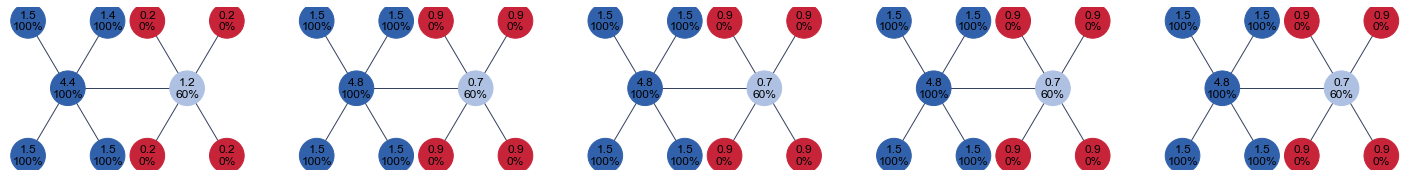

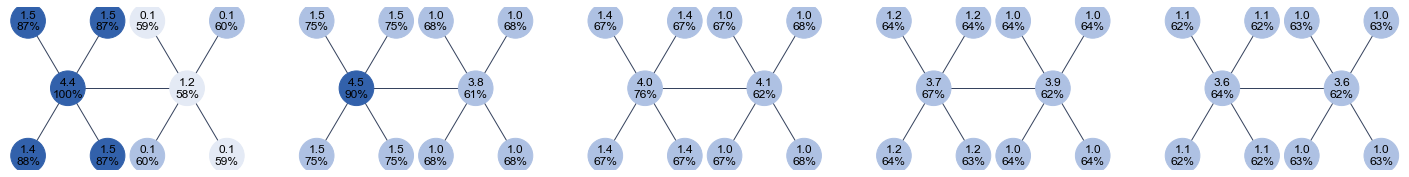

In [3]:
%%time
result_dict_list_list = [run_simulation(hop_learning = hop_learning) for hop_learning in [1, 2]]
for result_dict_list in result_dict_list_list:
    draw_graph_transition(result_dict_list, ncols = 5)